# Uplift-моделирование

В нашем распоряжении имеются данные о коммуникациях с покупателями (СМС-рассылка) и фактах покупки. Задача — построение предиктивной модели, которая поможет определить группу потребителей, которая наиболее подвержена влиянию и совершит покупку при коммуникации — т.е. uplift-моделирование.

Существует несколько традиционных подходов к выбору группы для коммуникации [[1]](https://habr.com/ru/company/ru_mts/blog/485980/):
- **Look-alike модель** — в это случае оценивается вероятность целевого действия на основе схожести покупателей по каким-то признакам, т.е. модель будет искать тех клиентов, которые похожи на тех, кто совершил целевое действие. В качестве обучающей выборки используются известные позитивные объекты и случайные негативные объекты;
- **Response модель** — оценивается вероятность целевого действия при условиях коммуникации В качестве обучающего набора данных здесь берутся датасеты с информацией о позитивных действиях после совершения некоторого взаимодействия с клиентов (реальные позитивные и негативные наблюдения после коммуникации);
- **Uplift модель** — оценивается **чистый** эффект от коммуникации. В этом случае модель пытается определить только тех клиентов, которым для совершения целевого действия необходимо воздействие.

$$ Uplift = P_{целевого-действия-при-коммуникации} - P_{целевого-действия-без-коммуникации} $$

В данном проекте мы будем использовать последний подход. Обычно он применяется, когда целевое действие выполняется клиентами с достаточно большой вероятностью без каких-либо коммуникаций — например, предлагается популярный продукт. Проблема оценки воздействия в том, что мы не можем одновременно совершить коммуникацию (например, послать смс) и не совершить коммуникацию (не послать смс).

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold, learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from feature_engine.encoding import OneHotEncoder

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


# модели
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

<span style="color:orange">Комментарий к ноутбуку:
Данный ноутбук можно считать скорее неудачным — выбранный в конце сабмит показал отвратительный скор на тестовой выборке. Тем не менее, поиск инсайтов для генерации фич, преобразование датасетов и примененный подход позволяют рассматривать его в качестве "вступления" к решению задачи аплифта</span>

## Обзор данных

Исхожные данные предоставлены в нескольких файлах:
- client2.csv — информация о клиентах;
- products.csv — информация о продуктах;
- train_purchases.csv — история покупок клиентов из тренировочного набора;
- test_purchases.csv — история покупок клиентов из теста;
- train.csv — тренировочные данные с указанием treatment_flg — была ли совершена коммуникация, purchased — была ли совершена покупка
- test.csv — тестовые данные.

Для тестовых данных необходимо предсказать вероятность того, что клиент купит только при коммуникации.

### Загрузка данных

In [2]:
# оффлайн
try:
    clients = pd.read_csv('clients2.csv')
    products = pd.read_csv('products.csv')
    train_purchases = pd.read_csv('train_purch.csv')
    train_data = pd.read_csv('train.csv')
    test_purchases = pd.read_csv('test_purch.csv')
    test_data = pd.read_csv('test.csv')

# на kaggle
except Exception():
    clients = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv')
    products = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv')
    train_purchases = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv.csv')
    train_data = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv')
    test_purchases = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv')
    test_data = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv')
    
    

### Обзор данных clients

In [3]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          200039 non-null  object 
 1   client_id.1        0 non-null       float64
 2   first_issue_date   200039 non-null  object 
 3   first_redeem_date  182493 non-null  object 
 4   age                200039 non-null  int64  
 5   gender             200039 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [4]:
clients.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [5]:
clients.describe()

,client_id.1,age
count,0.0,200039.000000
mean,NaN,46.417329
std,NaN,49.532475
min,NaN,-7491.000000
25%,NaN,34.000000
50%,NaN,45.000000
75%,NaN,59.000000
max,NaN,1852.000000


В нашем распоряжении имеются данные о 200 000 клиентах компании — их обезличенный идентификатор `client_id`, дата регистрации (или выпуска карты) `first_issue_date`, дата первого выкупа `first_redeem_date`. Прежде чем перейти к анализу, удалим столбец-признак `client_id.1` выгруженный с ошибкой.

In [6]:
clients = clients.drop(columns='client_id.1')

In [7]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


Агреггированные данные (метод `describe`) показали наличие в столбце `age` аномальных значений — минимальное значение является отрицательным, а максимальное — превышает тысячу лет. Посмотрим на количество выбросов, приняв за границу нижнюю границу "нормальности" 7 лет (дееспособность для мелких бытовых сделок), а за верхнюю — 100 лет.

In [8]:
clients[(clients['age']<7) | (clients['age']>100)]

,client_id,first_issue_date,first_redeem_date,age,gender
5,000220a0a7,2017-12-09 17:26:20,2018-10-04 14:59:29,115,M
47,000d599743,2018-08-29 09:08:39,NaN,959,U
882,0130b696fe,2018-07-29 21:25:26,2018-09-27 21:24:14,119,M
1179,018eab4dfe,2017-09-02 12:06:14,2018-06-11 10:50:37,108,U
1265,01a8fcf7e6,2017-06-15 13:45:33,2017-10-06 12:20:46,119,U
...,...,...,...,...,...
198928,fe9c17328e,2018-05-19 14:43:23,2018-09-25 18:24:33,931,U
199064,fec39b0d96,2018-11-15 11:03:26,2018-12-26 12:03:37,1,U
199500,ff4fadac9f,2017-04-12 16:37:40,2018-12-05 18:41:35,115,M
199557,ff6614ddd4,2018-12-02 22:41:58,2019-02-08 13:47:56,119,U


653 объекта с аномальными значениями — около 0.3% процента всего датасета. Удалим данные выбросы и посмотрим на распределение по возрасту после очистки данных.

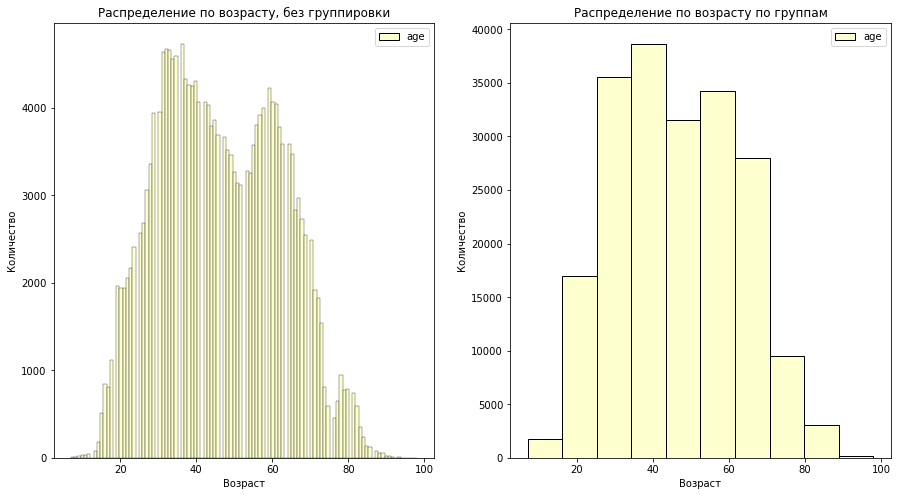

In [9]:
clients = clients[(clients['age']>6) & (clients['age'] < 100)]


fig = plt.figure(figsize = (15,8))
ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

hist_1 = sns.histplot(data = clients, palette = "RdYlBu", ax=ax_1)
ax_1.set_title('Распределение по возрасту, без группировки')
ax_1.set_xlabel('Возраст')
ax_1.set_ylabel('Количество')

hist_2 = sns.histplot(data = clients, palette = "RdYlBu", bins = 10, ax=ax_2)
ax_2.set_title('Распределение по возрасту по группам')
ax_2.set_xlabel('Возраст')
ax_2.set_ylabel('Количество')

plt.show()

In [10]:
clients.describe()

,age
count,199378.000000
mean,46.381191
std,15.909418
min,7.000000
25%,34.000000
50%,45.000000
75%,59.000000
max,98.000000


Медианное значение возраста — 45 лет, среднее — 46.38 . Однако, на графиках распределения видно, что в датасете преобладают две возрастные группы — от 30 до 40 и от 55 до 65 лет, которые в среднем и дают значение 46,3

### Обзор данных products

В products.csv сохранены данные от товарах. 

In [11]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43038 entries, 0 to 43037
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        43038 non-null  object 
 1   level_1           43035 non-null  object 
 2   level_2           43035 non-null  object 
 3   level_3           43035 non-null  object 
 4   level_4           43035 non-null  object 
 5   segment_id        41466 non-null  float64
 6   brand_id          37838 non-null  object 
 7   vendor_id         43004 non-null  object 
 8   netto             43035 non-null  float64
 9   is_own_trademark  43038 non-null  int64  
 10  is_alcohol        43038 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 3.6+ MB


В таблице — данные о 43038 товарах. По почти всем им имеются данных о некоторых "уровнях", сегментах к которым они принадлежат, производителе, вендоре, нетто-весе и информация, является ли данный товар собственной торговой маркой (далее СТМ) и алкоголем.

Попробуем проанализировать данные о "уровнях" — для этого посмотрим на уникальные значения в признаках — являются ли они уникальными для каждого товара (как product_id) или имеются общие значения для разных товаров.

In [13]:
products['level_1'].value_counts()

e344ab2e71    22183
c3d3a8e8c6    16573
ec62ce61e3     4279
Name: level_1, dtype: int64

Всего три значения — сложные кодированные значения можно заменить категориями.

In [14]:
products['level_2'].value_counts()

52f13dac0c    8891
ad2b2e17d2    6631
f2333c90fb    3310
ed2ad1797c    3257
703f4b6eb0    2396
749c619457    2393
14d373dff5    2377
c2a3ea8d5e    2209
1d2939ba1d    1717
f93982269d    1343
4202626fcb    1124
de6f3b925a     910
be86806c6b     757
6b4ae3f25d     570
a49a930a49     540
d283080a93     523
70ac384d6a     502
825fe699ab     441
034aca0659     383
f980df59e1     331
36bd2cad67     285
63852cb2ab     261
428e08386e     245
91fb12a54a     242
fb3d79909e     225
6f624f4be0     206
e8705574ff     174
b0c4967fce     125
93073a7304     114
79666b6e44     100
8a277809e5      87
3f9010c11e      74
fb84f08028      69
c6e84cdac8      56
26ae5a7da8      39
c3d6b407d9      36
a75f1bad01      18
35642addd4      17
3ef03403a0      17
a2963967ff      16
2ede06c1ee      14
15e7af62dd      10
Name: level_2, dtype: int64

In [15]:
len(products['level_2'].value_counts())

42

По второму "уровню" товары сегментированы уже на 42 группы.

In [16]:
products['level_3'].value_counts()

ca69ed9de2    3737
419bc5b424    2729
0f84eb7480    2571
38816369ce    2324
6b55683dad    1862
              ... 
d26b025821       1
b62e37b39d       1
cf7a66aa8b       1
475f86c453       1
c0a411f3b8       1
Name: level_3, Length: 201, dtype: int64

По третьему — на 201 группу.

In [17]:
products['level_4'].value_counts()

420c3b3f0b    2500
4d4b7e1f16    2077
3a074a6620    1485
6dc544533f    1313
b4b0e4c470     784
              ... 
48aaaf19eb       1
6eae515849       1
1ed02fb53a       1
f4584a44cc       1
b94bdd1be8       1
Name: level_4, Length: 790, dtype: int64

На четвертом "уровне" выделено уже 790 групп товаров. Посмотрим выборочно на какую-нибудь группу.

In [18]:
products[products['level_1'] == 'ec62ce61e3'].head(15)

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
13,0016914eaa,ec62ce61e3,8a277809e5,d605ac2b79,fbbd117fd7,102.0,0d6f137fb6,8ad28e1ef9,0.023,0,0
51,0043d0725f,ec62ce61e3,a49a930a49,08efd6b20e,69c2604ded,35.0,0d6f137fb6,f3e7cd2a2a,0.214,0,0
62,005b7e7c92,ec62ce61e3,be86806c6b,58f4db5467,39459b730f,45.0,NaN,c63add1307,0.020,0,0
65,0063bcd598,ec62ce61e3,c6e84cdac8,1eccbc65f5,89906089c7,80.0,767e3af396,056b1621ca,0.129,0,0
69,00678eb1df,ec62ce61e3,a49a930a49,d1dc20357f,e83e5f0a95,NaN,NaN,01f7c589b1,0.038,0,0
70,0067d95477,ec62ce61e3,4202626fcb,a8db01db9c,8ad4eec70f,260.0,8642da17ad,43acd80c1a,0.020,1,0
97,009caf4750,ec62ce61e3,93073a7304,b30f37e434,33756a6077,260.0,4da2dc345f,1962dd9523,0.250,0,0
98,009dd67cb8,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,10a37e42c7,31be4d3c13,0.113,0,0
122,00c935c63f,ec62ce61e3,36bd2cad67,edbe75f28a,22aaba47b2,75.0,0d6f137fb6,2d5c53ab8a,0.069,0,0


В одной товарной группе по первому уровню оказались товары с разной сегментацией по остальным уровням, от разных произвоителей, разных вендоров  с разным весом.

Вероятно, для всей товарной матрицы проведен некий анализ (наподобие ABC-анализа), по которым каждый продукт отнесен к разным сегментам по 4 разным признакам.

In [19]:
products[products['level_1'].isna()] # пропуски

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
796,04d86b4b50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12219,48cc0e256d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
17818,6a3d708544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Для трех продуктов совсем отсутствует информация.

In [20]:
products.segment_id.value_counts()

105.0    5360
150.0    2745
271.0    1690
259.0    1523
85.0     1291
         ... 
23.0       10
211.0       7
171.0       6
258.0       3
144.0       3
Name: segment_id, Length: 116, dtype: int64

Еще одна внутренняя сегментация делит товары на 116 категорий — в некоторые из них отнесено большое количество товаров, в другие  всего несколько.

In [21]:
products.brand_id.value_counts()

0d6f137fb6    4344
4da2dc345f    3071
b06ace74de     385
ab230258e9     268
63ba6b7a61     136
              ... 
2bccf1cb99       1
217417efc0       1
17c536543f       1
0656953a5e       1
b10d46da5c       1
Name: brand_id, Length: 4296, dtype: int64

В датасете предствалены два крупных бренда (> 3000 товаров) и множество (>4000) мелких.

In [22]:
products.vendor_id.value_counts() 

43acd80c1a    1514
63243765ed     349
c4e167b91e     331
83f98e6dc3     328
4f276b13c1     323
              ... 
f9574ad995       1
a35f34b4fb       1
dc19e275e7       1
809dd55029       1
6cc8ce0e52       1
Name: vendor_id, Length: 3193, dtype: int64

Вендоров в датасете меньше — но исходя из несоответсвия между количеством товаров крупнейшими брендами и количеством товаров, поставляемых крупнейшими вендорами, можно сделать вывод, что один бренд представляют сразу несколько вендоров.

Масса продукта — `netto` вряд ли стоит анализировать в рамках данного проекта.

Переходим к одному из наиболее значимых признаков товара — является ли он СТМ.

In [23]:
products.is_own_trademark.value_counts(normalize=True)

0    0.964822
1    0.035178
Name: is_own_trademark, dtype: float64

Доля СТМ во всем ассортименте — чуть более 3,5%. 

In [24]:
products.is_alcohol.value_counts(normalize=True)

0    0.944398
1    0.055602
Name: is_alcohol, dtype: float64

Доля алкоголя в ассортименте — 5,5 %. Посмотрим есть ли алкоголь под собственной торговой маркой:

In [25]:
products[products['is_own_trademark'] == 1].is_alcohol.value_counts(normalize=True)

0    0.716645
1    0.283355
Name: is_alcohol, dtype: float64

Не просто есть — 28% продуктов СТМ — алкоголь.

In [26]:
products[products['is_alcohol'] == 1].is_own_trademark.value_counts(normalize=True)

0    0.820727
1    0.179273
Name: is_own_trademark, dtype: float64

А доля СТМ в алкоголе — почти 18%.

### Обзор данных train_purchases и train

В `train_purchases` хранится история покупок клиентов из тренировочного набора данных. Их следует рассматривать вместе с данными из `train.csv`: данных о клиентах для обучения, с указанием `treatment_flg` — была ли совершена коммуникация, `purchased` — была ли совершена покупка.

In [27]:
train_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 1.5+ GB


In [28]:
train_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


В датасете почти 16 млн строк:
- `client_id` — уникальный идентификатор пользователя;
- `transaction_id` — идентификатор покупки (трансакции);
- `transaction_datetime` — дата трансакции;
- `regular_points_received` — полученные очки системы лояльности;
- `express_points_received` — полученные дополнительные (специальные?) очки системы лояльности;
- `regular_points_spent` — потраченные обычные очки системы лояльности;
- `express_points_spent` — потраченные дополнительные очки системы лояльности;
- `purchase_sum` — общая сумма покупки;
- `store_id` — идентификатор в каком магазине была совершена покупка;
- `product_id` — идентификатор продукта, который был куплен;
- `product_quantity` — количесвто приобретенного продукта; 
- `trn_sum_from_iss`, `trn_sum_from_red` — доля продукта в общей покупке;


Посмотрим на максимальную сумму покупки в тренировочных данных:

In [29]:
train_purchases['purchase_sum'].max()

29611.48

Теперь определим, за какой период у нас имеются данные. Для этого понадобится преобразовать тип данных в столбце `transaction_datetime`

In [30]:
train_purchases['transaction_datetime'] = pd.to_datetime(train_purchases['transaction_datetime'], format='%Y-%m-%d %H:%M:%S')

In [31]:
train_purchases['transaction_datetime'].describe()

<ipython-input-31-170a531ba987>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_purchases['transaction_datetime'].describe()


count                15998952
unique                2193591
top       2019-03-03 10:48:55
freq                      123
first     2018-11-21 21:02:33
last      2019-03-18 23:19:28
Name: transaction_datetime, dtype: object

Первая покупка в датасете датирована 21 ноября 2018 года, а последняя — 18 марта 2019 года.

In [32]:
train_purchases.groupby('client_id')['transaction_id'].count()

client_id
000012768d     52
000036f903    162
0001f552b0     86
00020e7b18    272
000220a0a7     85
             ... 
fffd5cd0c6    100
fffd63dfe3     25
fffd8c9d7d     20
fffe0abb97     38
fffeca6d22     54
Name: transaction_id, Length: 140027, dtype: int64

Всего в трейне 140 027 уникальных покупателей.

In [33]:
train_purchases['date'] = pd.to_datetime(train_purchases['transaction_datetime']).dt.date

In [34]:
len(train_purchases['transaction_id'].unique()) / len(train_purchases['date'].unique())

23855.872881355932

В среднем в магазинах совершается 23 856 сделок в день — это и есть математическое ожидание количества сделок.

Теперь посмотрим на данные из train.csv — и наложим их на данных о покупках покупателей.

In [35]:
train_data.head()

,client_id,treatment_flg,purchased
0,ad6561e2d8,1,1
1,7c1ccbf93f,1,1
2,b58fadcab6,1,1
3,e99e6fabb9,0,0
4,27fb6f8520,1,1


In [36]:
train_data.duplicated().sum()

0

In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140027 entries, 0 to 140026
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      140027 non-null  object
 1   treatment_flg  140027 non-null  int64 
 2   purchased      140027 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


Количество покупателей в датасете совпадает с их количеством в истории покупок — ошибки выгрузки нет. Сам датасет предствляет собой таблицу с двумя признаками:
- `treatment_flg` — была ли проведена коммуникация;
- `purchased` — была ли совершена покупка.

Посмотрим, как соотносятся классы в тренировочных данных:

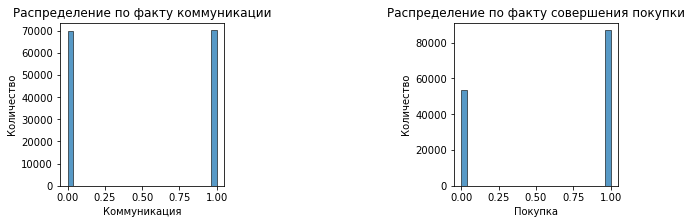

In [38]:
figure = plt.figure(figsize=(10,3))
ax_1 = figure.add_subplot(1,3,1)
ax_2 = figure.add_subplot(1,3,3)

hist_1 = sns.histplot(data = train_data['treatment_flg'], palette = "RdYlBu", ax=ax_1)
ax_1.set_title('Распределение по факту коммуникации')
ax_1.set_xlabel('Коммуникация')
ax_1.set_ylabel('Количество')

hist_1 = sns.histplot(data = train_data['purchased'], palette = "RdYlBu", ax=ax_2)
ax_2.set_title('Распределение по факту совершения покупки')
ax_2.set_xlabel('Покупка')
ax_2.set_ylabel('Количество')

plt.show()

Как видно из графиков, классы по факту совершения коммуникации в датасете сбалансированны (50:50). А вот по факту покупки — нет: очевидно, что среди тех с кем не коммуницировали тоже есть те, кто совершили покупку.

Посмотрим значение аплифта на тренировочных данных — для этого рассчитаем разницу между средним количеством купивших без коммуникации и средним количеством купивших с коммуникацией.

In [39]:
train_data[train_data['treatment_flg'] == 1]['purchased'].mean() \
- train_data[train_data['treatment_flg'] == 0]['purchased'].mean()

# использован перенос строки для приведения к правилам PEP8


0.03354516795221374

Аплифт — 3,34%

Посмотрим, как соотносятся половозрастные группы в трейне и как демографические факторы влияют на аплифт внутри групп.

Присоединим к `train`' данные из датасета, сохраненного в `clients`.

In [40]:
train_data = pd.merge(train_data, clients, how="inner", on=["client_id"])

In [41]:
train_data

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F
...,...,...,...,...,...,...,...
139547,999d284453,1,1,2018-10-31 13:10:37,2019-04-06 13:49:41,72,U
139548,f634deea4e,0,1,2018-02-04 13:51:32,2018-03-12 17:41:42,35,U
139549,16cb4f99b0,0,1,2018-02-23 10:02:33,2019-05-31 17:37:36,50,F
139550,23c2b72b2e,1,1,2017-07-01 19:05:33,2017-10-18 18:50:02,55,U


In [42]:
clients['gender'].unique()

array(['U', 'F', 'M'], dtype=object)

У нас есть три значения для пола:
- `U` — предположительно `undefined` — неопределен;
- `F` — `female` — женский пол;
- `M` — `male` — мужской.

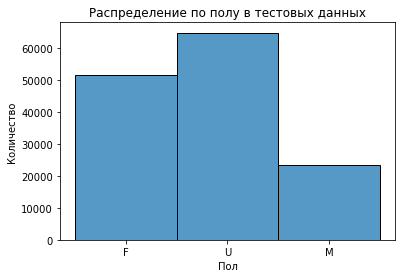

In [43]:
fig, ax = plt.subplots()

sns.histplot(train_data['gender'],palette = "RdYlBu")
plt.title('Распределение по полу в тестовых данных')
ax.set_xlabel('Пол')
ax.set_ylabel('Количество');

Большинство клиентов не указали свою принадлежность к определенному гендеру. На графике точно видно — мужчины в меньшистве (или чаще не указывают свой пол).

In [44]:
train_data.gender.value_counts(normalize=True)

U    0.463426
F    0.369353
M    0.167221
Name: gender, dtype: float64

Посмотрим на медианное значение возраста в трейне.

In [45]:
train_data['age'].describe()

count    139552.000000
mean         46.391338
std          15.899749
min           7.000000
25%          34.000000
50%          45.000000
75%          59.000000
max          96.000000
Name: age, dtype: float64

Возрастной портрет клиентов в выборке для трейна повторяет портрет по всем клиентам. Средний возраст — 46,39, медианный — 45.

Посмотрим, делает ли возраст людей более восприимчивыми к коммуникации — для этого посчитаем аплифт по возрастной группе старше 50 лет и у тех, кто младше.

In [46]:
train_data_over_50 = train_data[train_data['age'] > 50]

train_data_over_50[train_data_over_50['treatment_flg'] == 1]['purchased'].mean() \
- train_data_over_50[train_data_over_50['treatment_flg'] == 0]['purchased'].mean()

0.05078708426818468

In [47]:
train_data_under_50 = train_data[train_data['age'] <= 50]

train_data_under_50[train_data_under_50['treatment_flg'] == 1]['purchased'].mean() \
- train_data_under_50[train_data_under_50['treatment_flg'] == 0]['purchased'].mean()

0.02126838772391415

Так и есть! Люди предпенсионного возраста и на пенсии лучше реагируют на коммуникацию. Аплифт больше более чем в 2 раза.

In [48]:
del train_data_under_50
del train_data_over_50

Посмотрим, какая доля покупок СТМ среди всем покупок. Напомним, что доля СТМ в ассортименте составляет чуть более 3,5%.

In [49]:
train_purchases = pd.merge(train_purchases, products[['product_id','is_own_trademark']], how="left", on=["product_id"])

In [50]:
train_purchases['trn_sum_from_iss'].sum()

1174099057.0

In [51]:
train_purchases[train_purchases['is_own_trademark'] == 1]['trn_sum_from_iss'].sum()

114424361.0

In [52]:
Out[51]/Out[50]

0.0974571611464977

В тренировачных данных на СТМ приходится 9,74% оборота. Но нам также нужно учесть и тестовые данные. 

In [53]:
test_purchases_1 = test_purchases

In [54]:
test_purchases_1 = pd.merge(test_purchases_1, products[['product_id','is_own_trademark']], how="left", on=["product_id"])

In [55]:
test_purchases_1['trn_sum_from_iss'].sum()

505985703.0

In [56]:
test_purchases_1[test_purchases_1['is_own_trademark'] == 1]['trn_sum_from_iss'].sum()

49374171.0

In [58]:
(Out[56]+Out[51])/(Out[50]+Out[55])

0.09749420737558502

In [59]:
test_purchases_1.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,is_own_trademark
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,NaN,0
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,NaN,0
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,NaN,1
3,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,5c6de3010f,2.0,85.0,NaN,0
4,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,343e841aaa,1.0,58.0,NaN,0


In [60]:
products[products['product_id'] == 'a375a035b9']

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
27327,a375a035b9,e344ab2e71,ed2ad1797c,0767853bf3,f8174fb475,14.0,ab230258e9,57ee56f098,0.36,0,0


In [61]:
test_purchases_1[test_purchases_1['transaction_id']=='e91ffe5b50']

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,is_own_trademark
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,NaN,0
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,NaN,0
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,NaN,1
3,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,5c6de3010f,2.0,85.0,NaN,0
4,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,343e841aaa,1.0,58.0,NaN,0


In [62]:
del test_purchases_1

Влияет ли факт покупки самого популярного продукта на аплифт? Если влияет, то каково значение аплифта?

Определим самый популярный продукт — для этого посчитаем сколько раз он встречается у разных покупателей.

In [63]:
train_purchases_temp = train_purchases.pivot_table(index=['product_id'], values=['client_id'], aggfunc=['count'])

In [64]:
train_purchases_temp.columns = ['count']

In [65]:
train_purchases_temp.sort_values(by='count', ascending=False)

,count
product_id,
4009f09b04,636488
15ccaa8685,219727
bf07df54e1,144643
3e038662c0,134126
4dcf79043e,129695
...,...
c01c981c64,1
2837a6825a,1
bffdeb943c,1


Некий товар с `product_id` 4009f09b04 купили 636488. Создадим по нему признак для клиентов в трейне.

In [66]:
del train_purchases_temp

Создадим список с id клиентов, которые покупали самый популярный продукт.

In [67]:
list_of_clients_buying_most_popular = train_purchases[train_purchases['product_id']=='4009f09b04']['client_id'].unique()

Теперь определим фунцию, которая проверит есть ли клиент в этом списке.

In [68]:
def fill_buy_most_popular(row):
    """
    Функция принимает на вход строку датафрейма с имеющимся признаком `client_id`,
    и проверяет, входит ли этот id в список тех кто покупал самый популярный продукт.
    """
    if row['client_id'] in list_of_clients_buying_most_popular:
        return 1
    else:
        return 0

In [69]:
train_data['buys_most_popular'] = train_data.apply(fill_buy_most_popular, axis=1)

In [70]:
train_data.head() #проверем добавление признака

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1


In [71]:
train_data_popular = train_data[train_data['buys_most_popular'] == 1]

train_data_popular[train_data_popular['treatment_flg'] == 1]['purchased'].mean() \
- train_data_popular[train_data_popular['treatment_flg'] == 0]['purchased'].mean()

0.026455617315496616

Аплифт среди тех, кто покупал самый популярный продукт примерно равнен 2,6% против 3,3% по всем тренировочным данным.

Посмотрим, на сколько со временем падает эффект от коммуникации — разделим пользователей на тех кто владеет картой более 100 дней и менее и сравним аплифт. Тут будет сделано допущение, что дата последней покупки - дата коммуникации.

In [72]:
train_data['first_issue_date'] = pd.to_datetime(train_data['first_issue_date'], format='%Y-%m-%d')

In [73]:
train_data['current_date'] = pd.Timestamp('2019-03-18')

In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139552 entries, 0 to 139551
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          139552 non-null  object        
 1   treatment_flg      139552 non-null  int64         
 2   purchased          139552 non-null  int64         
 3   first_issue_date   139552 non-null  datetime64[ns]
 4   first_redeem_date  127270 non-null  object        
 5   age                139552 non-null  int64         
 6   gender             139552 non-null  object        
 7   buys_most_popular  139552 non-null  int64         
 8   current_date       139552 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 10.6+ MB


In [75]:
train_data['tenure'] = train_data['current_date'] - train_data['first_issue_date']

In [76]:
train_data = train_data.drop(columns='current_date')

In [77]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139552 entries, 0 to 139551
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   client_id          139552 non-null  object         
 1   treatment_flg      139552 non-null  int64          
 2   purchased          139552 non-null  int64          
 3   first_issue_date   139552 non-null  datetime64[ns] 
 4   first_redeem_date  127270 non-null  object         
 5   age                139552 non-null  int64          
 6   gender             139552 non-null  object         
 7   buys_most_popular  139552 non-null  int64          
 8   tenure             139552 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(4), object(3), timedelta64[ns](1)
memory usage: 10.6+ MB


In [78]:
train_data['tenure'] = train_data['tenure'].dt.days.astype('int16')

In [79]:
train_data

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1,469
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1,492
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1,500
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0,305
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1,608
...,...,...,...,...,...,...,...,...,...
139547,999d284453,1,1,2018-10-31 13:10:37,2019-04-06 13:49:41,72,U,0,137
139548,f634deea4e,0,1,2018-02-04 13:51:32,2018-03-12 17:41:42,35,U,1,406
139549,16cb4f99b0,0,1,2018-02-23 10:02:33,2019-05-31 17:37:36,50,F,0,387
139550,23c2b72b2e,1,1,2017-07-01 19:05:33,2017-10-18 18:50:02,55,U,1,624


Рассчет даты владения картой для трейна сделан — теперь посмотрим на аплифт по группам.

In [80]:
train_data_card_over_100 = train_data[train_data['tenure'] > 100]

train_data_card_over_100[train_data_card_over_100['treatment_flg'] == 1]['purchased'].mean() \
- train_data_card_over_100[train_data_card_over_100['treatment_flg'] == 0]['purchased'].mean()

0.030981550901291177

In [81]:
train_data_card_under_100 = train_data[train_data['tenure'] <= 100]

train_data_card_under_100[train_data_card_under_100['treatment_flg'] == 1]['purchased'].mean() \
- train_data_card_under_100[train_data_card_under_100['treatment_flg'] == 0]['purchased'].mean()

0.0555896169903326

В группе А (владеют картой более 100 дней) аплифт меньше, чем в группе Б(владеют менее 100 дней), на 2,35 п.п.

In [82]:
del train_data_card_over_100
del train_data_card_under_100

Следуюший шаг — определить, влияет ли факт покупки СТМ на аплифт. Для этого разделим покупателей на две категории — те, кто никогда не покупал СТМ, и те, кто покупал хоть раз.

In [83]:
train_purchases_temp = train_purchases[['client_id','product_id','is_own_trademark']]

In [84]:
train_purchases_temp = train_purchases_temp[train_purchases_temp['is_own_trademark'] == 1] \
                                        .drop(columns=['product_id']).drop_duplicates()

In [85]:
train_purchases_temp #список id клиентов покупавших СТМ

,client_id,is_own_trademark
1,000012768d,1
54,000036f903,1
225,0001f552b0,1
303,00020e7b18,1
579,000220a0a7,1
...,...,...
15998728,fffd5cd0c6,1
15998817,fffd63dfe3,1
15998841,fffd8c9d7d,1
15998861,fffe0abb97,1


135712 клиентов из 140 000 покупали СТМ.

In [86]:
train_data = pd.merge(train_data, train_purchases_temp[['client_id','is_own_trademark']], how="left", on=["client_id"]).fillna(0)

In [87]:
train_data

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure,is_own_trademark
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1,469,1.0
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1,492,1.0
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1,500,1.0
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0,305,1.0
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1,608,1.0
...,...,...,...,...,...,...,...,...,...,...
139547,999d284453,1,1,2018-10-31 13:10:37,2019-04-06 13:49:41,72,U,0,137,1.0
139548,f634deea4e,0,1,2018-02-04 13:51:32,2018-03-12 17:41:42,35,U,1,406,1.0
139549,16cb4f99b0,0,1,2018-02-23 10:02:33,2019-05-31 17:37:36,50,F,0,387,1.0
139550,23c2b72b2e,1,1,2017-07-01 19:05:33,2017-10-18 18:50:02,55,U,1,624,1.0


In [88]:
train_data[train_data['is_own_trademark']==0] #посмотрим на покупателей, избегающих СТМ

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure,is_own_trademark
45,d5409afb67,1,1,2018-07-26 21:20:51,2018-09-08 16:58:51,35,U,0,234,0.0
69,a3315dbb52,1,0,2017-10-19 15:33:39,2017-12-28 15:49:10,34,F,0,514,0.0
116,d47aa22157,1,0,2019-03-09 11:47:32,2019-05-01 11:58:43,60,F,0,8,0.0
124,bb2f77391b,1,0,2017-09-26 19:55:03,2018-03-29 19:15:14,57,F,0,537,0.0
147,8e94027336,1,0,2017-12-06 12:45:32,2018-12-15 15:55:49,70,F,0,466,0.0
...,...,...,...,...,...,...,...,...,...,...
139441,1a03e05ce2,0,0,2019-03-09 08:31:11,2019-05-26 11:13:28,24,M,0,8,0.0
139462,fed6d022d8,0,1,2018-06-24 14:00:53,2019-02-15 13:09:02,70,F,0,266,0.0
139496,60679240d9,0,0,2017-04-16 17:50:38,2017-10-07 13:21:15,61,U,0,700,0.0
139537,5abeaba527,1,0,2017-10-18 08:38:28,2018-02-12 14:57:49,46,M,0,515,0.0


In [89]:
del train_purchases_temp

In [90]:
train_data = train_data.rename(columns={'is_own_trademark':'buying_own_trademark'})

In [91]:
train_data_buying_own_trademark = train_data[train_data['buying_own_trademark'] == 1]

train_data_buying_own_trademark[train_data_buying_own_trademark['treatment_flg'] == 1]['purchased'].mean() \
- train_data_buying_own_trademark[train_data_buying_own_trademark['treatment_flg'] == 0]['purchased'].mean()

0.03183387309537422

In [92]:
train_data_not_buying_own_trademark = train_data[train_data['buying_own_trademark'] == 0]

train_data_not_buying_own_trademark[train_data_not_buying_own_trademark['treatment_flg'] == 1]['purchased'].mean() \
- train_data_not_buying_own_trademark[train_data_not_buying_own_trademark['treatment_flg'] == 0]['purchased'].mean()

0.0782835779819297

In [93]:
0.07828 - 0.031833

0.046447

Аплифт среди тех кто избегает СТМ сильно выше, чем среди тех, кто покупает СТМ — разница почти 5 п.п.

Разделим покупателей на две группы. В группе А у большей части покупок клиента чек больше среднего чека по всей выборке. В группе Б у  большей части покупок клиента чек меньше среднего чека по всей выборке. Правда ли то, что аплифт в группе А меньше, чем в группе Б?

Рассчитаем количесвто визитов трейне для каждого покупателя:

In [94]:
train_data['total_purchase'] = pd.DataFrame(list(train_purchases.groupby('client_id').agg({'transaction_id' : ['count']})['transaction_id']['count']))
train_data.head()

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure,buying_own_trademark,total_purchase
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1,469,1.0,52
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1,492,1.0,162
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1,500,1.0,86
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0,305,1.0,272
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1,608,1.0,85


Создадим временный датасет в котором выведем для каждого покупателя дату покупки и ее сумму

In [95]:
df_1 = train_purchases.groupby(['client_id', 'transaction_datetime']).agg({'purchase_sum' : ['count']})
df_2 = train_purchases.groupby(['client_id', 'transaction_datetime']).agg({'purchase_sum' : ['sum']})
df_purchase = df_2['purchase_sum']['sum'] / df_1['purchase_sum']['count']
df_purchase

client_id   transaction_datetime
000012768d  2018-12-01 07:12:45     1007.0
            2018-12-16 08:56:01      574.0
            2019-03-08 10:12:03      803.0
            2019-03-14 15:01:47      419.0
000036f903  2018-11-28 10:48:36      241.0
                                     ...  
fffeca6d22  2019-02-22 09:34:13      110.0
            2019-02-22 09:34:53      138.0
            2019-02-28 10:25:24      128.0
            2019-03-09 07:47:43       99.0
            2019-03-15 14:46:39      165.0
Length: 2814991, dtype: float64

In [96]:
df_sum_purchase = pd.DataFrame(list(df_purchase.groupby('client_id').sum()))

In [97]:
df_sum_purchase

,0
0,2803.00
1,9805.00
2,6155.18
3,25819.61
4,8606.57
...,...
140022,5731.63
140023,1340.51
140024,1636.53
140025,2716.42


Такой подход удалил id клиентов — придется чинить

In [98]:
data_train_sum_purchase = pd.DataFrame()
data_train_sum_purchase['client_id'] = pd.Series(df_purchase.groupby('client_id').sum().index)
data_train_sum_purchase['sum_purchase'] = pd.Series(list(df_purchase.groupby('client_id').sum()))
data_train_sum_purchase.head(3)

,client_id,sum_purchase
0,000012768d,2803.00
1,000036f903,9805.00
2,0001f552b0,6155.18


In [99]:
data_train_sum_purchase

,client_id,sum_purchase
0,000012768d,2803.00
1,000036f903,9805.00
2,0001f552b0,6155.18
3,00020e7b18,25819.61
4,000220a0a7,8606.57
...,...,...
140022,fffd5cd0c6,5731.63
140023,fffd63dfe3,1340.51
140024,fffd8c9d7d,1636.53
140025,fffe0abb97,2716.42


In [100]:
train_data = pd.merge(train_data, data_train_sum_purchase[['client_id','sum_purchase']], how='left', on=['client_id'])

In [101]:
train_data['average_visit'] = train_data['sum_purchase'] / train_data['total_purchase']

In [102]:
train_data

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1,469,1.0,52,10801.41,207.719423
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1,492,1.0,162,851.00,5.253086
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1,500,1.0,86,14171.77,164.788023
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0,305,1.0,272,2872.00,10.558824
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1,608,1.0,85,9886.21,116.308353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139547,999d284453,1,1,2018-10-31 13:10:37,2019-04-06 13:49:41,72,U,0,137,1.0,30,2978.00,99.266667
139548,f634deea4e,0,1,2018-02-04 13:51:32,2018-03-12 17:41:42,35,U,1,406,1.0,23,10549.03,458.653478
139549,16cb4f99b0,0,1,2018-02-23 10:02:33,2019-05-31 17:37:36,50,F,0,387,1.0,79,3140.00,39.746835
139550,23c2b72b2e,1,1,2017-07-01 19:05:33,2017-10-18 18:50:02,55,U,1,624,1.0,163,3470.74,21.292883


In [103]:
train_data['sum_purchase'].sum()/train_data['total_purchase'].sum()

75.157353347458

Средняя сумма чека — 75,16 .

In [104]:
train_data_above_average = train_data[train_data['average_visit'] > 75.16]

train_data_above_average[train_data_above_average['treatment_flg'] == 1]['purchased'].mean() \
- train_data_above_average[train_data_above_average['treatment_flg'] == 0]['purchased'].mean()

0.02665154420298721

In [105]:
train_data_under_average = train_data[train_data['average_visit'] <= 75.16]

train_data_under_average[train_data_under_average['treatment_flg'] == 1]['purchased'].mean() \
- train_data_under_average[train_data_under_average['treatment_flg'] == 0]['purchased'].mean()

0.04021615288023561

Аплифт среди тех, чей средний чек меньше среднего по всей выборке больще на 1,4 п.п.

## Обучение модели

### Подготовка тренировочных данных

Перед тем, как перейти к обучению модели, посмотрим какой набор признаков мы получили 

In [106]:
train_data.head()

,client_id,treatment_flg,purchased,first_issue_date,first_redeem_date,age,gender,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit
0,ad6561e2d8,1,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,1,469,1.0,52,10801.41,207.719423
1,7c1ccbf93f,1,1,2017-11-10 16:33:49,2018-02-22 19:02:25,24,F,1,492,1.0,162,851.00,5.253086
2,b58fadcab6,1,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,1,500,1.0,86,14171.77,164.788023
3,e99e6fabb9,0,0,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,0,305,1.0,272,2872.00,10.558824
4,27fb6f8520,1,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,1,608,1.0,85,9886.21,116.308353


In [107]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139552 entries, 0 to 139551
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   client_id             139552 non-null  object        
 1   treatment_flg         139552 non-null  int64         
 2   purchased             139552 non-null  int64         
 3   first_issue_date      139552 non-null  datetime64[ns]
 4   first_redeem_date     139552 non-null  object        
 5   age                   139552 non-null  int64         
 6   gender                139552 non-null  object        
 7   buys_most_popular     139552 non-null  int64         
 8   tenure                139552 non-null  int16         
 9   buying_own_trademark  139552 non-null  float64       
 10  total_purchase        139552 non-null  int64         
 11  sum_purchase          139552 non-null  float64       
 12  average_visit         139552 non-null  float64       
dtyp

У нас есть:
- возраст;
- пол;
- покупает ли клиент самый популярный товар;
- срок владения картой;
- покупает ли СТМ;
- общее количество покупок;
- общая сумма покупок;
- средний чек за визит.

Перед обучением модели необходимо сделать следующие преобразования:
    - удалить `client_id` т.к. не является по сути признаков;
    - рассчитать время между оформлением карты и ее первым использованием;
    - удалить конкретные даты оформления и использования карты;
    
Для части моделей также необходимо будет привести категориальные признаки. Мы планируем использовать модель Catboost которая справляется с категориальными фитчами, но изменим их на случай, если захотим позже обучить другие модели.

In [108]:
train_data['first_redeem_date'] = pd.to_datetime(train_data['first_redeem_date'], format='%Y-%m-%d %H:%M:%S')

In [109]:
train_data['days_for_first_use'] = (train_data['first_redeem_date'] - train_data['first_issue_date']).dt.days.astype('int16')

In [110]:
train_data = train_data.drop(columns=['first_issue_date','first_redeem_date','client_id'])

In [111]:
train_data.head(10)

,treatment_flg,purchased,age,gender,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit,days_for_first_use
0,1,1,50,F,1,469,1.0,52,10801.41,207.719423,171
1,1,1,24,F,1,492,1.0,162,851.00,5.253086,104
2,1,1,36,U,1,500,1.0,86,14171.77,164.788023,316
3,0,0,79,F,0,305,1.0,272,2872.00,10.558824,14
4,1,1,34,F,1,608,1.0,85,9886.21,116.308353,150
5,1,1,35,U,1,228,1.0,116,37948.40,327.141379,163
6,1,0,61,F,0,392,1.0,72,1632.00,22.666667,129
7,1,0,44,F,1,521,1.0,140,3822.62,27.304429,90
8,0,1,33,U,1,628,1.0,83,14228.23,171.424458,15
9,0,1,39,U,1,15,1.0,107,2800.11,26.169252,16


In [112]:
train_data = pd.get_dummies(train_data, columns = ['gender'], drop_first=True)

In [113]:
train_data.head()

,treatment_flg,purchased,age,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit,days_for_first_use,gender_M,gender_U
0,1,1,50,1,469,1.0,52,10801.41,207.719423,171,0,0
1,1,1,24,1,492,1.0,162,851.00,5.253086,104,0,0
2,1,1,36,1,500,1.0,86,14171.77,164.788023,316,0,1
3,0,0,79,0,305,1.0,272,2872.00,10.558824,14,0,0
4,1,1,34,1,608,1.0,85,9886.21,116.308353,150,0,0


### Отделение целевого признака

В дальшейшей работе мы пойдем следующим путем:
- обучим модель на тренировочных данных с указанием, была ли совершена коммуникация;
- добавим все расчетные признаки в тестовые данные;
- дважды сделаем предсказания для каждого клиента в тесте — с указанием флага коммуникации и без него;
- те пользователи, которые изменили группу в зависимости от факта коммуникации и интересуют нас — им и нужно отправлять СМС.

In [114]:
target = train_data['purchased']                          # определяем целевой признак
features = train_data.drop('purchased', axis=1)           # отделяем все остальные признаки

# 10% для валидации модели

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.1,
                                                                              random_state=1049)

In [115]:
features_train.shape

(125596, 11)

In [116]:
target_train.shape

(125596,)

In [117]:
features_valid.shape

(13956, 11)

In [118]:
target_valid.shape

(13956,)

In [119]:
model = CatBoostClassifier(random_state = 1049, verbose=100, )

grid = {'learning_rate': [0.01, 0.1],
        'depth': [4, 6, 10]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6913733	test: 0.6913718	best: 0.6913718 (0)	total: 499ms	remaining: 8m 18s
100:	learn: 0.6160725	test: 0.6158718	best: 0.6158718 (100)	total: 2.24s	remaining: 19.9s
200:	learn: 0.6025059	test: 0.6022392	best: 0.6022392 (200)	total: 4.03s	remaining: 16s
300:	learn: 0.5985986	test: 0.5982932	best: 0.5982932 (300)	total: 5.77s	remaining: 13.4s
400:	learn: 0.5968199	test: 0.5965189	best: 0.5965189 (400)	total: 7.28s	remaining: 10.9s
500:	learn: 0.5957572	test: 0.5954543	best: 0.5954543 (500)	total: 8.81s	remaining: 8.77s
600:	learn: 0.5950874	test: 0.5948313	best: 0.5948313 (600)	total: 10.3s	remaining: 6.83s
700:	learn: 0.5945558	test: 0.5944225	best: 0.5944225 (700)	total: 11.8s	remaining: 5.02s
800:	learn: 0.5941281	test: 0.5941009	best: 0.5941009 (800)	total: 13.2s	remaining: 3.28s
900:	learn: 0.5937627	test: 0.5938641	best: 0.5938641 (900)	total: 14.8s	remaining: 1.62s
999:	learn: 0.5934379	test: 0.5936904	best: 0.5936904 (999)	total: 16.2s	remaining: 0us

bestTest = 0.593

In [120]:
predictions_valid = model.predict(features_valid)

In [121]:
predictions_valid_proba = model.predict_proba(features_valid)

In [122]:
predictions_valid_proba

array([[0.24929591, 0.75070409],
       [0.36696305, 0.63303695],
       [0.34011363, 0.65988637],
       ...,
       [0.30409647, 0.69590353],
       [0.34144945, 0.65855055],
       [0.49470192, 0.50529808]])

In [123]:
probabilities_one_valid = predictions_valid_proba[:, 1]

In [124]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7010596739876028


ROC-AUC имеет значение 0.7 — далеко до желаемой единицы, но уже что-то

Попробуем увеличить гиперпараметр `learning_rate` и передадим в качестве функции потерь непосредственно AUC

In [125]:
model = CatBoostClassifier(random_state = 1049, verbose=100, eval_metric='AUC', iterations=200 )

grid = {'learning_rate': [0.001, 0.01, 0.1],
        'depth': [4, 6, 10, 20, 100]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6853675	best: 0.6853675 (0)	total: 16.9ms	remaining: 3.36s
100:	test: 0.7015105	best: 0.7015777 (71)	total: 1.64s	remaining: 1.61s
199:	test: 0.7016576	best: 0.7016663 (196)	total: 3.28s	remaining: 0us

bestTest = 0.7016663294
bestIteration = 196

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7016663	best: 0.7016663 (0)	total: 3.58s	remaining: 50.1s
0:	test: 0.6853675	best: 0.6853675 (0)	total: 15.9ms	remaining: 3.17s
100:	test: 0.7057241	best: 0.7057603 (99)	total: 1.88s	remaining: 1.84s
199:	test: 0.7087662	best: 0.7087662 (199)	total: 3.59s	remaining: 0us

bestTest = 0.7087662402
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7087662	best: 0.7087662 (1)	total: 7.19s	remaining: 46.7s
0:	test: 0.6853675	best: 0.6853675 (0)	total: 18ms	remaining: 3.58s
100:	tes

In [126]:
predictions_valid_proba = model.predict_proba(features_valid)
probabilities_one_valid = predictions_valid_proba[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7053278595934422


Незначительно улучшение параметра достугнуто.

### Преобразование тестового датасета

Перед загрузкой тестового датасета очистим память от лишних переменных.

In [127]:
train_data.to_csv('my_train_data.csv')

In [128]:
del train_data
del train_purchases

In [129]:
test_data

,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8
3,dceb8ce861
4,f4f0ac6b06
...,...
60007,4762fb04c5
60008,533d1516e7
60009,c93b21a707
60010,3fe0668de5


Как и ожидалось, в тесте — только id клиентов — сюда и надо будет наростить фитчи.

In [130]:
test_purchases = pd.read_csv('test_purch.csv')

In [131]:
test_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883738 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 682.7+ MB


#### Добавляем время владения картой, пол и возвраст присоединяя clients

In [132]:
test_data = pd.merge(test_data, clients, how='left', on=['client_id'])

In [133]:
test_data

,client_id,first_issue_date,first_redeem_date,age,gender
0,a9a604ed6e,2018-09-13 17:36:41,NaN,36.0,F
1,ebd7360016,2017-07-03 17:12:12,2017-09-01 16:15:12,63.0,F
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F
3,dceb8ce861,2017-10-06 17:06:42,2018-08-11 18:43:58,46.0,U
4,f4f0ac6b06,NaN,NaN,NaN,NaN
...,...,...,...,...,...
60007,4762fb04c5,2018-05-31 16:03:28,2018-12-26 14:03:30,26.0,M
60008,533d1516e7,2017-09-29 08:27:16,2018-01-07 17:36:31,37.0,M
60009,c93b21a707,2018-10-03 21:02:26,2019-03-30 17:40:42,42.0,U
60010,3fe0668de5,2018-12-25 18:27:14,2019-02-02 10:30:53,33.0,U


Заметим что есть Nan значения — их надо будет заполнить

#### Покупка самого популярного товара для теста

In [134]:
test_purchases['transaction_datetime'] = pd.to_datetime(test_purchases['transaction_datetime'], format='%Y-%m-%d %H:%M:%S')

In [135]:
test_purchases = pd.merge(test_purchases, products[['product_id','is_own_trademark']], how="left", on=["product_id"])

Переопределим список для теста

In [136]:
list_of_clients_buying_most_popular = test_purchases[test_purchases['product_id']=='4009f09b04']['client_id'].unique()

In [137]:
test_data['buys_most_popular'] = test_data.apply(fill_buy_most_popular, axis=1)

In [138]:
test_data[test_data['buys_most_popular']==1]

,client_id,first_issue_date,first_redeem_date,age,gender,buys_most_popular
0,a9a604ed6e,2018-09-13 17:36:41,NaN,36.0,F,1
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F,1
4,f4f0ac6b06,NaN,NaN,NaN,NaN,1
6,e3574a0076,2017-08-11 15:20:53,2017-11-01 16:14:29,32.0,F,1
7,4789764e7d,2017-07-11 14:56:26,2017-12-30 17:56:58,54.0,U,1
...,...,...,...,...,...,...
60007,4762fb04c5,2018-05-31 16:03:28,2018-12-26 14:03:30,26.0,M,1
60008,533d1516e7,2017-09-29 08:27:16,2018-01-07 17:36:31,37.0,M,1
60009,c93b21a707,2018-10-03 21:02:26,2019-03-30 17:40:42,42.0,U,1
60010,3fe0668de5,2018-12-25 18:27:14,2019-02-02 10:30:53,33.0,U,1


41 316 клиентов трейне покупают самый популярный товар.

#### Срок владения картой для трейна

In [139]:
test_data['first_issue_date'] = test_data['first_issue_date'].fillna(0)

In [140]:
test_data['first_redeem_date'] = test_data['first_redeem_date'].fillna(0)

In [141]:
test_data['current_date'] = pd.Timestamp('2019-03-18')

In [142]:
test_data['first_issue_date'] = pd.to_datetime(test_data['first_issue_date'], format='%Y-%m-%d %H:%M:%S')

In [143]:
test_data['first_redeem_date'] = pd.to_datetime(test_data['first_redeem_date'], format='%Y-%m-%d %H:%M:%S')

In [144]:
test_data['tenure'] = test_data['current_date'] - test_data['first_issue_date']

In [145]:
test_data['tenure'] = test_data['tenure'].dt.days.astype('int16')

In [146]:
test_data

,client_id,first_issue_date,first_redeem_date,age,gender,buys_most_popular,current_date,tenure
0,a9a604ed6e,2018-09-13 17:36:41,1970-01-01 00:00:00,36.0,F,1,2019-03-18,185
1,ebd7360016,2017-07-03 17:12:12,2017-09-01 16:15:12,63.0,F,0,2019-03-18,622
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F,1,2019-03-18,352
3,dceb8ce861,2017-10-06 17:06:42,2018-08-11 18:43:58,46.0,U,0,2019-03-18,527
4,f4f0ac6b06,1970-01-01 00:00:00,1970-01-01 00:00:00,NaN,NaN,1,2019-03-18,17973
...,...,...,...,...,...,...,...,...
60007,4762fb04c5,2018-05-31 16:03:28,2018-12-26 14:03:30,26.0,M,1,2019-03-18,290
60008,533d1516e7,2017-09-29 08:27:16,2018-01-07 17:36:31,37.0,M,1,2019-03-18,534
60009,c93b21a707,2018-10-03 21:02:26,2019-03-30 17:40:42,42.0,U,1,2019-03-18,165
60010,3fe0668de5,2018-12-25 18:27:14,2019-02-02 10:30:53,33.0,U,1,2019-03-18,82


#### Покупка СТМ

In [147]:
test_purchases_temp = test_purchases[['client_id','product_id','is_own_trademark']]

In [148]:
test_purchases_temp = test_purchases_temp[test_purchases_temp['is_own_trademark'] == 1] \
                                        .drop(columns=['product_id']).drop_duplicates()

In [149]:
test_data = pd.merge(test_data, test_purchases_temp[['client_id','is_own_trademark']], how="left", on=["client_id"]).fillna(0)

In [150]:
test_data = test_data.rename(columns={'is_own_trademark':'buying_own_trademark'})

In [151]:
test_data.head()

,client_id,first_issue_date,first_redeem_date,age,gender,buys_most_popular,current_date,tenure,buying_own_trademark
0,a9a604ed6e,2018-09-13 17:36:41,1970-01-01 00:00:00,36.0,F,1,2019-03-18,185,1.0
1,ebd7360016,2017-07-03 17:12:12,2017-09-01 16:15:12,63.0,F,0,2019-03-18,622,1.0
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F,1,2019-03-18,352,1.0
3,dceb8ce861,2017-10-06 17:06:42,2018-08-11 18:43:58,46.0,U,0,2019-03-18,527,1.0
4,f4f0ac6b06,1970-01-01 00:00:00,1970-01-01 00:00:00,0.0,0,1,2019-03-18,17973,1.0


#### Количество визитов, сумма покупок, средняя сумма покупки

In [152]:
test_data['total_purchase'] = pd.DataFrame(list(test_purchases.groupby('client_id').agg({'transaction_id' : ['count']})['transaction_id']['count']))
test_data.head()

,client_id,first_issue_date,first_redeem_date,age,gender,buys_most_popular,current_date,tenure,buying_own_trademark,total_purchase
0,a9a604ed6e,2018-09-13 17:36:41,1970-01-01 00:00:00,36.0,F,1,2019-03-18,185,1.0,78
1,ebd7360016,2017-07-03 17:12:12,2017-09-01 16:15:12,63.0,F,0,2019-03-18,622,1.0,26
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F,1,2019-03-18,352,1.0,158
3,dceb8ce861,2017-10-06 17:06:42,2018-08-11 18:43:58,46.0,U,0,2019-03-18,527,1.0,122
4,f4f0ac6b06,1970-01-01 00:00:00,1970-01-01 00:00:00,0.0,0,1,2019-03-18,17973,1.0,28


In [153]:
df_1 = test_purchases.groupby(['client_id', 'transaction_datetime']).agg({'purchase_sum' : ['count']})
df_2 = test_purchases.groupby(['client_id', 'transaction_datetime']).agg({'purchase_sum' : ['sum']})
df_purchase = df_2['purchase_sum']['sum'] / df_1['purchase_sum']['count']
df_purchase

client_id   transaction_datetime
00010925a5  2018-11-25 10:56:18     303.0
            2018-12-01 09:17:18     132.0
            2018-12-03 07:52:46     149.0
            2018-12-06 09:59:19     349.0
            2018-12-17 12:51:26     581.0
                                    ...  
fffff6ce77  2019-02-28 12:56:31     446.0
            2019-03-05 15:07:03     247.0
            2019-03-06 16:26:35     109.0
            2019-03-06 16:53:10     245.0
            2019-03-15 17:47:02     676.0
Length: 1209950, dtype: float64

In [154]:
df_sum_purchase = pd.DataFrame(list(df_purchase.groupby('client_id').sum()))

In [155]:
data_test_sum_purchase = pd.DataFrame()
data_test_sum_purchase['client_id'] = pd.Series(df_purchase.groupby('client_id').sum().index)
data_test_sum_purchase['sum_purchase'] = pd.Series(list(df_purchase.groupby('client_id').sum()))
data_test_sum_purchase.head(3)

,client_id,sum_purchase
0,00010925a5,5883.00
1,00035a21d9,1791.94
2,00038f9200,8385.00


In [156]:
test_data = pd.merge(test_data, data_test_sum_purchase[['client_id','sum_purchase']], how='left', on=['client_id'])

In [157]:
test_data.head()

,client_id,first_issue_date,first_redeem_date,age,gender,buys_most_popular,current_date,tenure,buying_own_trademark,total_purchase,sum_purchase
0,a9a604ed6e,2018-09-13 17:36:41,1970-01-01 00:00:00,36.0,F,1,2019-03-18,185,1.0,78,3147.53
1,ebd7360016,2017-07-03 17:12:12,2017-09-01 16:15:12,63.0,F,0,2019-03-18,622,1.0,26,5680.57
2,908cd9b8e8,2018-03-30 17:01:20,2018-07-13 17:05:52,49.0,F,1,2019-03-18,352,1.0,158,6193.04
3,dceb8ce861,2017-10-06 17:06:42,2018-08-11 18:43:58,46.0,U,0,2019-03-18,527,1.0,122,8265.26
4,f4f0ac6b06,1970-01-01 00:00:00,1970-01-01 00:00:00,0.0,0,1,2019-03-18,17973,1.0,28,8960.00


In [158]:
test_data['average_visit'] = test_data['sum_purchase'] / test_data['total_purchase']

#### Категоризируем гендер

In [159]:
test_data['gender'] = test_data['gender'].fillna('U')

In [160]:
test_data = pd.get_dummies(test_data, columns = ['gender'], drop_first=True)

In [161]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60012 entries, 0 to 60011
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             60012 non-null  object        
 1   first_issue_date      60012 non-null  datetime64[ns]
 2   first_redeem_date     60012 non-null  datetime64[ns]
 3   age                   60012 non-null  float64       
 4   buys_most_popular     60012 non-null  int64         
 5   current_date          60012 non-null  datetime64[ns]
 6   tenure                60012 non-null  int16         
 7   buying_own_trademark  60012 non-null  float64       
 8   total_purchase        60012 non-null  int64         
 9   sum_purchase          60012 non-null  float64       
 10  average_visit         60012 non-null  float64       
 11  gender_F              60012 non-null  uint8         
 12  gender_M              60012 non-null  uint8         
 13  gender_U        

In [162]:
test_data['days_for_first_use'] = (test_data['first_redeem_date'] - test_data['first_issue_date']).dt.days.astype('int16')

In [163]:
# сохраняем id 
# clients_id = test_data['client_id']

In [164]:
test_data = test_data.drop(columns=['current_date','first_issue_date','first_redeem_date','client_id'])

In [165]:
test_data

,age,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit,gender_F,gender_M,gender_U,days_for_first_use
0,36.0,1,185,1.0,78,3147.53,40.352949,1,0,0,-17788
1,63.0,0,622,1.0,26,5680.57,218.483462,1,0,0,59
2,49.0,1,352,1.0,158,6193.04,39.196456,1,0,0,105
3,46.0,0,527,1.0,122,8265.26,67.748033,0,0,1,309
4,0.0,1,17973,1.0,28,8960.00,320.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
60007,26.0,1,290,1.0,64,11462.29,179.098281,0,1,0,208
60008,37.0,1,534,1.0,97,994.47,10.252268,0,1,0,100
60009,42.0,1,165,1.0,172,9591.75,55.765988,0,0,1,177
60010,33.0,1,82,1.0,61,2817.00,46.180328,0,0,1,38


In [166]:
test_data = test_data.drop(columns=['gender_F'])

### Устанавливаем флаг коммуникации для всех в тесте в позицию 1

In [167]:
test_data['treatment_flg']=1 

In [168]:
test_data.shape

(60012, 11)

In [169]:
predictions_test_proba = model.predict_proba(test_data)
probabilities_one_test = predictions_test_proba[:, 1]

In [170]:
probabilities_one_test

array([0.30397829, 0.76201865, 0.65605835, ..., 0.69275261, 0.52346646,
       0.63443487])

In [171]:
data_test_sum_purchase = pd.DataFrame()
data_test_sum_purchase['client_id'] = pd.Series(df_purchase.groupby('client_id').sum().index)
data_test_sum_purchase['sum_purchase'] = pd.Series(list(df_purchase.groupby('client_id').sum()))
data_test_sum_purchase.head(3)

,client_id,sum_purchase
0,00010925a5,5883.00
1,00035a21d9,1791.94
2,00038f9200,8385.00


In [172]:
test_clienst_id = pd.read_csv('test.csv')

In [173]:
submission_zero = pd.DataFrame()
submission_zero['client_id'] = test_clienst_id['client_id']
submission_zero['pred'] = pd.Series(list(probabilities_one_test))
submission_zero.drop

<bound method DataFrame.drop of         client_id      pred
0      a9a604ed6e  0.303978
1      ebd7360016  0.762019
2      908cd9b8e8  0.656058
3      dceb8ce861  0.720781
4      f4f0ac6b06  0.626897
...           ...       ...
60007  4762fb04c5  0.736355
60008  533d1516e7  0.295205
60009  c93b21a707  0.692753
60010  3fe0668de5  0.523466
60011  8d1ea24f5e  0.634435

[60012 rows x 2 columns]>

In [174]:
submission_zero

,client_id,pred
0,a9a604ed6e,0.303978
1,ebd7360016,0.762019
2,908cd9b8e8,0.656058
3,dceb8ce861,0.720781
4,f4f0ac6b06,0.626897
...,...,...
60007,4762fb04c5,0.736355
60008,533d1516e7,0.295205
60009,c93b21a707,0.692753
60010,3fe0668de5,0.523466


In [175]:
submission_zero.to_csv('submission_zero.csv', index=False)

Таргет определен неправильно — и пока качество хуже бейзлайна.

### Устанавливаем флаг коммуникации для всех в тесте в позицию 0

In [176]:
test_data['treatment_flg']=0

In [177]:
test_data

,age,buys_most_popular,tenure,buying_own_trademark,total_purchase,sum_purchase,average_visit,gender_M,gender_U,days_for_first_use,treatment_flg
0,36.0,1,185,1.0,78,3147.53,40.352949,0,0,-17788,0
1,63.0,0,622,1.0,26,5680.57,218.483462,0,0,59,0
2,49.0,1,352,1.0,158,6193.04,39.196456,0,0,105,0
3,46.0,0,527,1.0,122,8265.26,67.748033,0,1,309,0
4,0.0,1,17973,1.0,28,8960.00,320.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
60007,26.0,1,290,1.0,64,11462.29,179.098281,1,0,208,0
60008,37.0,1,534,1.0,97,994.47,10.252268,1,0,100,0
60009,42.0,1,165,1.0,172,9591.75,55.765988,0,1,177,0
60010,33.0,1,82,1.0,61,2817.00,46.180328,0,1,38,0


In [178]:
predictions_test_proba = model.predict_proba(test_data)
probabilities_zero_test = predictions_test_proba[:, 1]

In [179]:
probabilities_zero_test

array([0.2925841 , 0.72090203, 0.62432665, ..., 0.66875686, 0.47128414,
       0.61743611])

### Аплифт

In [180]:
calculate_proba = pd.DataFrame()

In [181]:
calculate_proba['zero_proba'] = pd.Series(list(probabilities_zero_test))

In [182]:
def get_class_zero(row):
    if row['zero_proba'] >= 0.5:
        return 1
    else:
        return 0

In [183]:
calculate_proba['class_with_treat_0'] = calculate_proba.apply(get_class_zero, axis=1)

In [184]:
calculate_proba['one_proba'] = pd.Series(list(probabilities_one_test))

In [185]:
def get_class_one(row):
    if row['one_proba'] >= 0.5:
        return 1
    else:
        return 0

In [186]:
calculate_proba['class_with_treat_1'] = calculate_proba.apply(get_class_one, axis=1)

In [187]:
calculate_proba

,zero_proba,class_with_treat_0,one_proba,class_with_treat_1
0,0.292584,0,0.303978,0
1,0.720902,1,0.762019,1
2,0.624327,1,0.656058,1
3,0.701152,1,0.720781,1
4,0.597347,1,0.626897,1
...,...,...,...,...
60007,0.714832,1,0.736355,1
60008,0.263684,0,0.295205,0
60009,0.668757,1,0.692753,1
60010,0.471284,0,0.523466,1


In [188]:
calculate_proba[(calculate_proba['class_with_treat_0'] == 0) & (calculate_proba['class_with_treat_1'] == 1)]

,zero_proba,class_with_treat_0,one_proba,class_with_treat_1
16,0.465863,0,0.502280,1
23,0.499393,0,0.546258,1
24,0.479198,0,0.524735,1
54,0.480864,0,0.511921,1
66,0.443732,0,0.503747,1
...,...,...,...,...
59966,0.486216,0,0.552039,1
59980,0.497571,0,0.524815,1
59999,0.485618,0,0.504108,1
60005,0.468036,0,0.523123,1


In [189]:
calculate_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60012 entries, 0 to 60011
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   zero_proba          60012 non-null  float64
 1   class_with_treat_0  60012 non-null  int64  
 2   one_proba           60012 non-null  float64
 3   class_with_treat_1  60012 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 1.8 MB


In [190]:
def get_uplift(row):
    class_proba = row['one_proba']*row['class_with_treat_1']
    return class_proba

In [191]:
calculate_proba = calculate_proba.apply(get_uplift, axis=1)

In [192]:
calculate_proba

0        0.000000
1        0.762019
2        0.656058
3        0.720781
4        0.626897
           ...   
60007    0.736355
60008    0.000000
60009    0.692753
60010    0.523466
60011    0.634435
Length: 60012, dtype: float64

In [193]:
submission_one = pd.DataFrame()
submission_one['client_id'] = test_clienst_id['client_id']
submission_one['pred'] = pd.Series(list(calculate_proba))


In [194]:
submission_one

,client_id,pred
0,a9a604ed6e,0.000000
1,ebd7360016,0.762019
2,908cd9b8e8,0.656058
3,dceb8ce861,0.720781
4,f4f0ac6b06,0.626897
...,...,...
60007,4762fb04c5,0.736355
60008,533d1516e7,0.000000
60009,c93b21a707,0.692753
60010,3fe0668de5,0.523466


In [195]:
submission_one.to_csv('submission_one.csv', index=False)

### Scikit

Подход напрямую не удался — время подключать готовые библиотеки.

In [196]:
test_data = test_data.drop(columns=['treatment_flg'])

In [197]:
!pip install scikit-uplift

In [198]:
data_train = pd.read_csv('my_train_data.csv')

In [199]:
data_train = pd.read_csv('my_train_data.csv').drop(columns=['Unnamed: 0'])

In [200]:
y_train = data_train['purchased']
treat_train = data_train['treatment_flg']
data_train.drop(['treatment_flg', 'purchased'], axis=1, inplace=True)
X_train = data_train

In [201]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [202]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [203]:
indices_learn, indices_valid = train_test_split(data_train.index, test_size=0.3, random_state=123)
indices_test = pd.Index(set(data_train.index) - set(['purchased', 'treatment_flg']))

In [204]:
X_val = X_train.loc[indices_valid, :]
y_val = y_train.loc[indices_valid]
treat_val = treat_train.loc[indices_valid]

In [205]:
lgb_model = LGBMClassifier(random_state=2021,
                           learning_rate=0.01,
                           max_depth=10,
                           metric="roc",
                           n_estimators=16000)

In [206]:
sm = SoloModel(lgb_model)
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

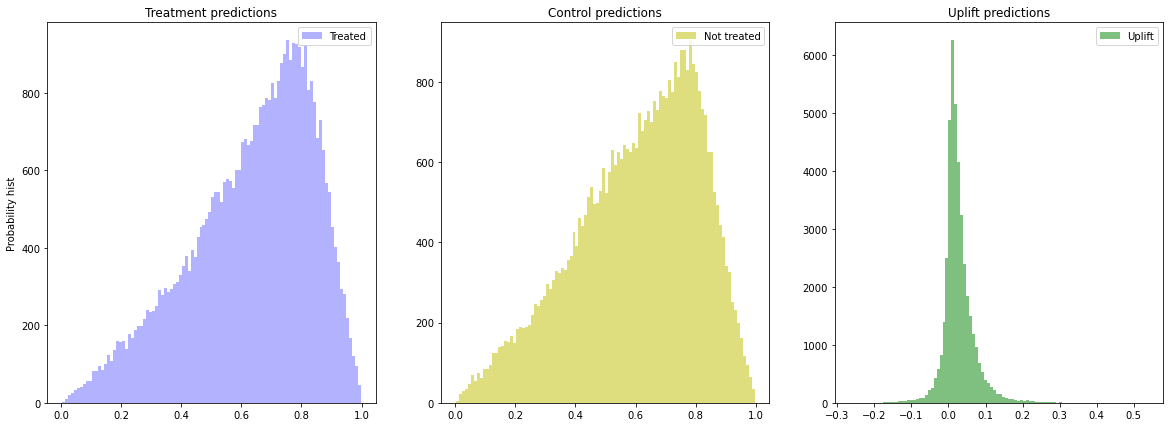

In [207]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [208]:
y_pred = sm.predict(test_data)

In [209]:
test_clienst_id['client_id']

0        a9a604ed6e
1        ebd7360016
2        908cd9b8e8
3        dceb8ce861
4        f4f0ac6b06
            ...    
60007    4762fb04c5
60008    533d1516e7
60009    c93b21a707
60010    3fe0668de5
60011    8d1ea24f5e
Name: client_id, Length: 60012, dtype: object

In [210]:
uplift_ans = pd.DataFrame({'client_id' : list(test_clienst_id['client_id']), 'pred': y_pred})
uplift_ans.to_csv("uplift.csv", index=False)

In [211]:
def get_zero(row):
    if row['pred'] < 0:
        return 0
    else:
        return row['pred']

In [212]:
uplift_ans['predictions'] = uplift_ans.apply(get_zero, axis=1)

In [213]:
uplift_ans

,client_id,pred,predictions
0,a9a604ed6e,0.050024,0.050024
1,ebd7360016,0.008332,0.008332
2,908cd9b8e8,0.034603,0.034603
3,dceb8ce861,0.040076,0.040076
4,f4f0ac6b06,0.165556,0.165556
...,...,...,...
60007,4762fb04c5,0.019677,0.019677
60008,533d1516e7,0.042372,0.042372
60009,c93b21a707,0.008054,0.008054
60010,3fe0668de5,0.035907,0.035907


In [214]:
uplift_ans_abs = pd.DataFrame({'client_id' : list(test_clienst_id['client_id']), 'pred': uplift_ans['predictions']})
uplift_ans_abs.to_csv("uplift_1.csv", index=False)

#### Catboost + Scikit

In [215]:
cat_model = CatBoostClassifier(random_state=2021,
                               learning_rate=0.1,
                               max_depth=10,
                               verbose=100,
                               eval_metric='AUC')

In [216]:
sm = SoloModel(cat_model)
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

0:	total: 84.3ms	remaining: 1m 24s
100:	total: 8.49s	remaining: 1m 15s
200:	total: 17.1s	remaining: 1m 7s
300:	total: 25.2s	remaining: 58.4s
400:	total: 33.2s	remaining: 49.6s
500:	total: 41.6s	remaining: 41.4s
600:	total: 52.2s	remaining: 34.6s
700:	total: 1m 3s	remaining: 27.3s
800:	total: 1m 12s	remaining: 18.1s
900:	total: 1m 21s	remaining: 9s
999:	total: 1m 29s	remaining: 0us


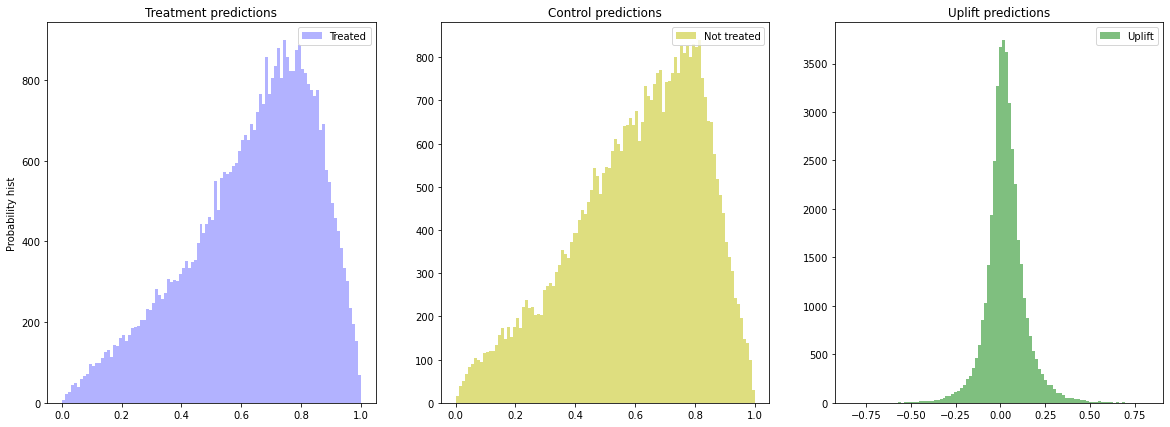

In [217]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [218]:
y_pred = sm.predict(test_data)

In [219]:
uplift_ans = pd.DataFrame({'client_id' : list(test_clienst_id['client_id']), 'pred': y_pred})
uplift_ans.to_csv("uplift_catboost.csv", index=False)

#### Среднее двух моделей

In [220]:
catboost_aswers = pd.read_csv("uplift_catboost.csv")

In [221]:
lightgbm_aswers = pd.read_csv("uplift.csv")

In [222]:
catboost_aswers['pred_lightgbm'] = lightgbm_aswers['pred']

In [223]:
catboost_aswers['mean_pred'] = (catboost_aswers['pred_lightgbm'] + catboost_aswers['pred']) /2

In [224]:
catboost_aswers

,client_id,pred,pred_lightgbm,mean_pred
0,a9a604ed6e,-0.034349,0.050024,0.007837
1,ebd7360016,0.079138,0.008332,0.043735
2,908cd9b8e8,0.047650,0.034603,0.041126
3,dceb8ce861,0.031785,0.040076,0.035930
4,f4f0ac6b06,0.153638,0.165556,0.159597
...,...,...,...,...
60007,4762fb04c5,0.008071,0.019677,0.013874
60008,533d1516e7,0.232493,0.042372,0.137432
60009,c93b21a707,0.099516,0.008054,0.053785
60010,3fe0668de5,0.047540,0.035907,0.041724


In [225]:
uplift_ans = pd.DataFrame({'client_id' : list(test_clienst_id['client_id']), 'pred': catboost_aswers['mean_pred']})
uplift_ans.to_csv("uplift_mean.csv", index=False)

#### Добавляем RandomForestClassifier

In [226]:
forest_model = RandomForestClassifier(random_state=2021,
                                      n_estimators=500)

In [227]:
sm = SoloModel(forest_model)
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

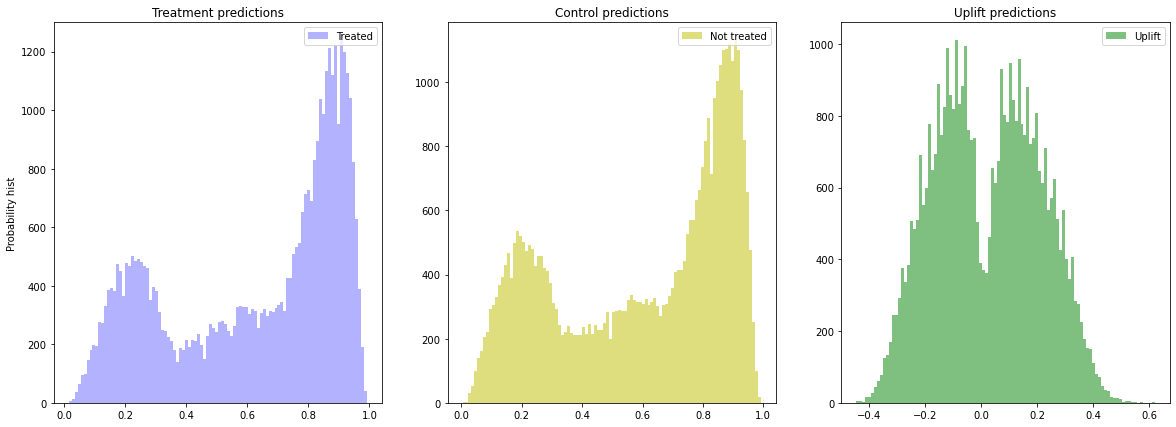

In [228]:
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Рисунок графиков сильно отличается от тех, что предлагали нам модели с градиентым бустингом — может быть случайный лес смог найти нужных клиентов?

In [229]:
y_pred = sm.predict(test_data)

C:\Users\rizho\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [230]:
catboost_aswers['forest_pred'] = pd.Series(list(y_pred))

In [231]:
catboost_aswers['mean_pred_2'] = (catboost_aswers['pred_lightgbm'] + catboost_aswers['pred'] + catboost_aswers['forest_pred']) /3

In [232]:
uplift_ans = pd.DataFrame({'client_id' : list(test_clienst_id['client_id']), 'pred': catboost_aswers['mean_pred_2']})
uplift_ans.to_csv("uplift_mean_with_forest.csv", index=False)

#### Выводы

Подключение случайного леса дало возможность улучшить метрику Gini на public . ДАльнейшеее улучшение модели связано с подключением новых признаков — временем между покупками, времени с последней покупки, указанием покупает ли конкретный клиент алкоголь, анализом очков системы лояльности.

Кроме того, учитывая что по мере подключения моделей мы получали все лучший скор, возможно следует добавить еще несколько простых моделей, которые выявят потеренных клиентов для аплифта.